# Model Training for Insurance Fraud Detection

This notebook focuses on developing predictive models to detect fraudulent insurance claims. It begins by loading the preprocessed and feature engineered dataset, followed by splitting the data into training and testing subsets to enable unbiased evaluation.

We then train multiple classification models including Logistic Regression as a baseline and Random Forest as a more powerful, nonlinear model and evaluate their performance with metrics suited for imbalanced classification problems, such as precision, recall, F1-score, ROC AUC, and Precision Recall AUC.

The notebook concludes with model comparison, visualization of key results, feature importance analysis for interpretability, and saving the best performing model pipeline for deployment and integration into reporting tools.

### Notebook Setup & Imports

This initial step sets up the environment by importing all necessary libraries and tools required for data manipulation, visualization, machine learning model training, evaluation, and saving. I also configured the environment to suppress warnings for cleaner output and establish consistent plot styling. This foundational setup ensures reproducibility and standardizes the coding environment before I begin any data operations or modeling.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, 
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve
)
import joblib
import warnings

# Ignore warnings for clean notebook output
warnings.filterwarnings('ignore')

# Set plot style for consistency
sns.set(style="whitegrid")

print("Libraries loaded.")

Libraries loaded.


### 1. Load Engineered Features

We load the fully preprocessed and feature engineered dataset prepared in earlier ETL and feature engineering steps. This dataset includes cleaned data with all necessary transformations and encoded variables, making it ready for model training. Confirming the data shape and previewing initial records help verify successful loading and give a quick snapshot of the dataset structure.

Purpose:
- Load the cleaned and feature engineered dataset
- Confirm dataset shape and preview first rows

In [2]:
# Define project directory and dataset file path
project_dir = r"C:\\Users\\Cloud\\OneDrive\\Desktop\\Fraud_Analytics_Project"
feature_file = os.path.join(project_dir, "data", "features", "engineered_insurance_claims.csv")

# Load dataset into a DataFrame
df = pd.read_csv(feature_file)

print("Feature dataset loaded. Shape:", df.shape)

# Preview first five rows to verify data loaded correctly
df.head()

Feature dataset loaded. Shape: (1000, 55)


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,incident_dayofweek,incident_day,incident_is_weekend,fraud_weight,incident_type_PARKED CAR,incident_type_SINGLE VEHICLE COLLISION,incident_type_VEHICLE THEFT,collision_type_REAR COLLISION,collision_type_SIDE COLLISION,police_report_available_YES
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,6,25,1,143220,False,True,False,False,True,True
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,2,21,0,0,False,False,True,False,False,False
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,6,22,1,69300,False,False,False,True,False,False
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,5,10,1,190200,False,True,False,False,False,False
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,17,0,6500,False,False,True,False,False,False


### 2 Inspect and Clean Feature Data Types

Before training any machine learning models, it's essential to ensure that the input features are numeric or boolean. Non-numeric columns, such as strings (`object` dtype), cannot be scaled or passed into most scikit-learn models without encoding.

In this step:
- I will inspect all current columns and their data types
- Identify and remove any leftover object-type columns from my feature_engineering notebook (e.g., `incident_date`, `policy_state`, `insured_occupation`)
- This guarantees that only numeric or boolean features are used for training and scaling

> Note: Important categorical features should have already been one-hot encoded in the feature engineering stage. This cleanup ensures the dataset is fully model-ready.

In [3]:
# Print a list of all column names in the current DataFrame
print("Columns in dataset:")
print(df.columns.tolist())

# Print the data types of each column
print("\nData types:")
print(df.dtypes)

# Drop raw string columns (object dtype) that cannot be scaled or modeled directly
df = df.drop(columns=df.select_dtypes(include=['object']).columns, errors='ignore')

# Confirm cleanup
print("\nRemaining columns after dropping object types:")
print(df.columns.tolist())

print("\nRemaining data types:")
print(df.dtypes.value_counts())

Columns in dataset:
['months_as_customer', 'age', 'policy_number', 'policy_bind_date', 'policy_state', 'policy_csl', 'policy_deductable', 'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex', 'insured_education_level', 'insured_occupation', 'insured_hobbies', 'insured_relationship', 'capital-gains', 'capital-loss', 'incident_date', 'incident_severity', 'authorities_contacted', 'incident_state', 'incident_city', 'incident_location', 'incident_hour_of_the_day', 'number_of_vehicles_involved', 'property_damage', 'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported', 'collision_type_missing_flag', 'police_report_available_missing_flag', 'property_damage_missing_flag', 'authorities_contacted_missing_flag', 'policy_csl_min', 'policy_csl_max', 'risk_score', 'incident_year', 'incident_month', 'incident_dayofweek', 'incident_day', 'incident_is_weekend', 'fraud_weight', '

### 3. Define Features and Target

Here, I separate the dataset into explanatory variables (`X`) and the target variable (`y`), which indicates whether a claim was fraudulent. I standardize all numeric features to normalize their scales. This is critical for models sensitive to feature magnitude differences, such as Logistic Regression, ensuring faster convergence and improved performance.

Purpose:
- Separate features `(X)` from target `(y)`
- Standardize numeric features for model training

In [4]:
# Drop target column to get features
X = df.drop(columns=['fraud_reported'])

# Target variable
y = df['fraud_reported']

# Save feature column names for later use
feature_names = X.columns.tolist()

# Initialize standard scaler
scaler = StandardScaler()

# Fit scaler and transform features, keep DataFrame format for clarity
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=feature_names)

print("Features and target separated. Scaling complete.")

Features and target separated. Scaling complete.


### 4. Train-Test Split

To fairly evaluate model generalization, I split the dataset into a training set used for model learning and a test set reserved for unbiased performance evaluation. Stratification maintains the original class imbalance distribution in both subsets, which is important due to the rarity of fraud cases and helps prevent biased model assessment.

Purpose:
- Split dataset into training and testing subsets
- Stratify to maintain fraud class distribution

In [5]:
# Perform train-test split (75% train, 25% test), stratify on target to balance classes
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

print("Train-test split complete.")
print("Training set:", X_train.shape)
print("Test set    :", X_test.shape)

Train-test split complete.
Training set: (750, 37)
Test set    : (250, 37)


### 5. Baseline Model - Logistic Regression

We implement Logistic Regression as a baseline model due to its interpretability and efficiency on tabular data. This simple linear model provides a benchmark performance level and insight into feature influence via coefficients. The classification report summarizes key metrics (precision, recall, F1-score), guiding us on model strengths and weaknesses in fraud detection.

Purpose:
- Train logistic regression as baseline classifier
- Generate classification report for evaluation

In [6]:
# Initialize Logistic Regression model with increased max iterations for convergence
logreg = LogisticRegression(max_iter=1000)

# Fit model on training data
logreg.fit(X_train, y_train)

# Predict on test set
y_pred_lr = logreg.predict(X_test)

# Display detailed classification metrics
print("Logistic Regression Report")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Report
              precision    recall  f1-score   support

           0       0.75      0.99      0.85       188
           1       0.00      0.00      0.00        62

    accuracy                           0.74       250
   macro avg       0.38      0.49      0.43       250
weighted avg       0.56      0.74      0.64       250



### 6. Train Random Forest Classifier

Next, I train a Random Forest model, this method builds multiple decision trees and aggregates their predictions. Random Forest often excels with tabular datasets and can capture complex nonlinear relationships. Comparing its performance to Logistic Regression helps me identify a more accurate and robust fraud detection model.

Purpose:
- Train a Random Forest, a robust tree-based classifier
- Compare performance with baseline Logistic Regression

In [7]:
# Initialize Random Forest with 100 trees
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit model on training data
rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf.predict(X_test)

# Show classification metrics for Random Forest
print("Random Forest Report")
print(classification_report(y_test, y_pred_rf))

Random Forest Report
              precision    recall  f1-score   support

           0       0.75      0.99      0.86       188
           1       0.33      0.02      0.03        62

    accuracy                           0.75       250
   macro avg       0.54      0.50      0.44       250
weighted avg       0.65      0.75      0.65       250



### 7. Visualize Confusion Matrices

Confusion matrices visually depict classification outcomes, showing true positives, false positives, true negatives, and false negatives. This step will help stakeholders understand types of errors each model makes, crucial in fraud detection where minimizing false negatives (missed frauds) can have significant cost implications.

Purpose:
- Plot confusion matrices to visually assess classification results

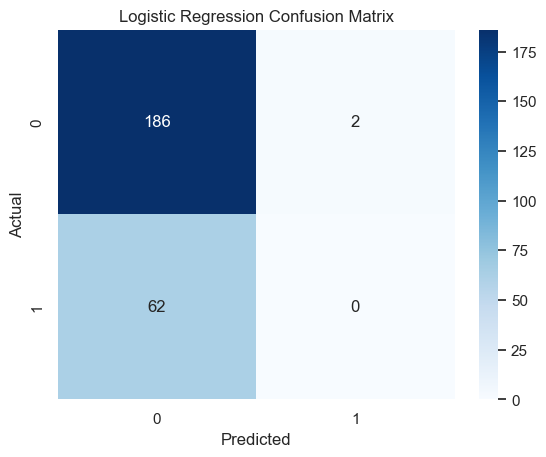

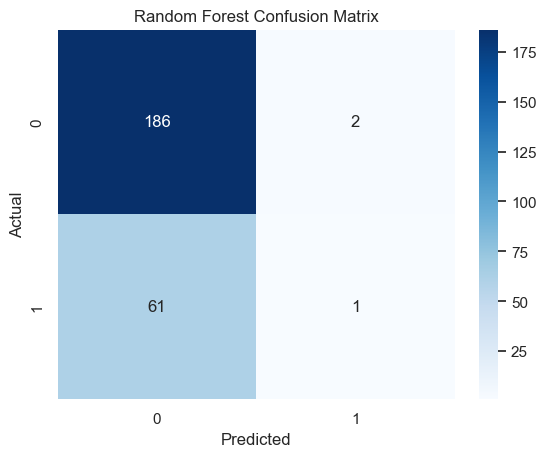

In [8]:
def plot_conf_matrix(y_true, y_pred, title):
    """
    Plot confusion matrix with annotations.
    
    Parameters:
    y_true: array-like, ground truth labels
    y_pred: array-like, predicted labels
    title: str, plot title
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot for Logistic Regression
plot_conf_matrix(y_test, y_pred_lr, "Logistic Regression Confusion Matrix")

# Plot for Random Forest
plot_conf_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

### 8. Performance Comparison

I quantitatively compare the models using the F1-score, a harmonic mean of precision and recall, which is a balanced measure especially valuable in imbalanced datasets like fraud detection. This informs which model better balances identifying fraud cases and limiting false alarms.

Purpose:
- Compare F1 scores of Logistic Regression and Random Forest models
- Use F1 due to class imbalance in fraud detection

In [9]:
# Calculate F1 scores for both models
f1_lr = f1_score(y_test, y_pred_lr)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"F1 Score - Logistic Regression: {f1_lr:.4f}")
print(f"F1 Score - Random Forest      : {f1_rf:.4f}")

F1 Score - Logistic Regression: 0.0000
F1 Score - Random Forest      : 0.0308


### 9. Evaluate Probabilistic Metrics

Beyond binary predictions, I assess model performance using probabilistic metrics: ROC AUC (Receiver Operating Characteristic Area Under Curve) and Precision Recall AUC. These metrics provide a nuanced view of model discrimination capability and effectiveness at various classification thresholds, critical in real world fraud risk prioritization.

Purpose:
- Compute ROC AUC and Precision Recall AUC for Random Forest
- Useful metrics under class imbalanc

In [10]:
# Predict fraud probabilities for positive class
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Calculate ROC AUC (area under ROC curve)
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))

# Calculate Precision-Recall AUC
print("PR AUC :", average_precision_score(y_test, y_prob_rf))

ROC AUC: 0.5649021962937543
PR AUC : 0.2887427410006145


### 10. ROC and Precision Recall Curves

Visualizing ROC and Precision Recall curves enables stakeholders to see how the model’s performance varies with different decision thresholds. These plots help choose thresholds that balance catching frauds and avoiding false positives, aligning model behavior with business risk appetite.

Purpose:
- Plot ROC and Precision Recall curves to visualize model threshold effects

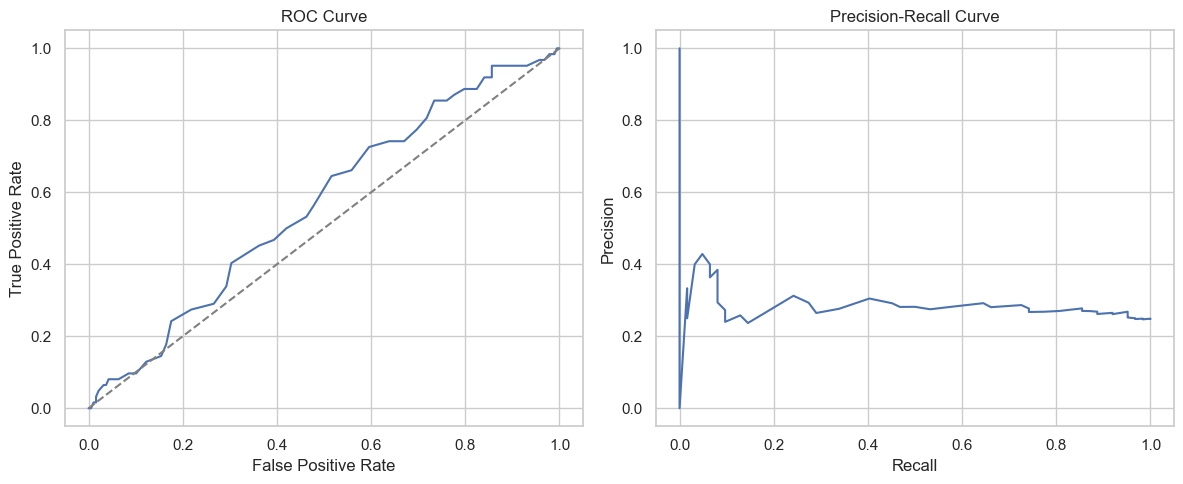

In [11]:
# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_rf)

# Compute Precision-Recall curve
prec, recall, _ = precision_recall_curve(y_test, y_prob_rf)

plt.figure(figsize=(12, 5))

# ROC curve subplot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Precision-Recall curve subplot
plt.subplot(1, 2, 2)
plt.plot(recall, prec, label="PR Curve")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")

plt.tight_layout()
plt.show()

### 11. Feature Importances (Random Forest)

Here, I extract and visualize the most influential features driving the Random Forest model’s decisions. Understanding which variables contribute most to detecting fraud aids in model explainability and builds stakeholder trust. It can also guide future data collection and feature engineering efforts.

Purpose:
- Identify the most important features used by the Random Forest model
- Helps with interpretability and insights

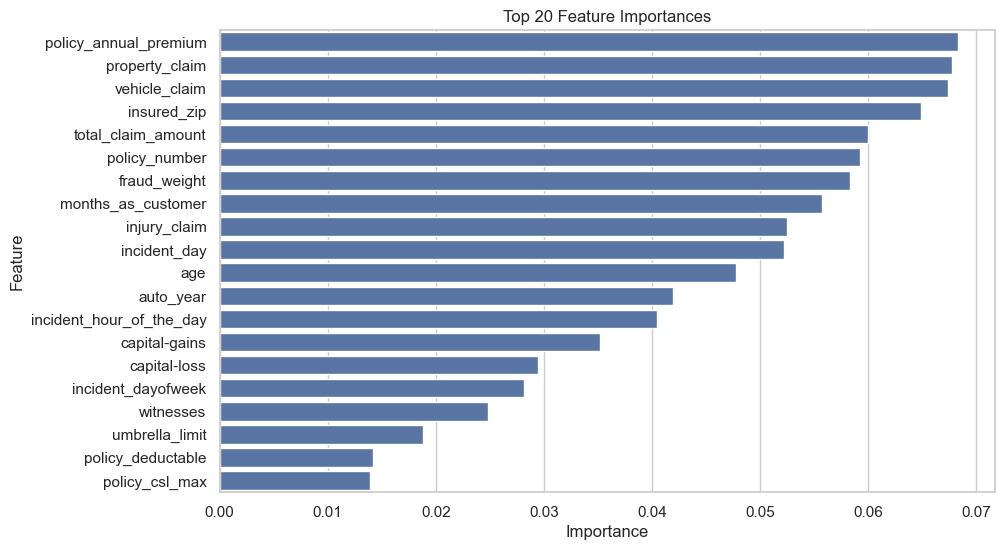

In [12]:
# Extract feature importances
importances = rf.feature_importances_

# Sort and take top 20 features
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)

# Plot feature importances as horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### 12. Save Best Model as Pipeline

For consistent deployment and future scoring, I save the entire processing and modeling pipeline (scaling + Random Forest) as a single object. This ensures that new data undergoes the same preprocessing steps before prediction, reducing errors and streamlining integration into production or dashboards.

Purpose:
- Save entire pipeline with scaler and Random Forest
- Ensures consistent preprocessing in deployment or dashboard

In [13]:
# Create pipeline that applies scaling and Random Forest in sequence
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit pipeline on training data
pipeline.fit(X_train, y_train)

# Create model directory if not exists
model_dir = os.path.join(project_dir, "models")
os.makedirs(model_dir, exist_ok=True)

# Save pipeline to disk
model_path = os.path.join(model_dir, "fraud_model_pipeline_rf.joblib")
joblib.dump(pipeline, model_path)

print(f"Best model saved to: {model_path}")

Best model saved to: C:\\Users\\Cloud\\OneDrive\\Desktop\\Fraud_Analytics_Project\models\fraud_model_pipeline_rf.joblib


### 13. Metadata Logging

I log library versions and run timestamps for reproducibility and audit purposes. This practice helps track the software environment under which the model was trained, supporting future debugging, retraining, and regulatory compliance.

Purpose:
- Log package versions and run date for reproducibility and reporting

In [14]:
import sklearn
import datetime

print("🔧 Versions and Metadata")
print("sklearn version:", sklearn.__version__)
print("pandas version:", pd.__version__)
print("Run date       :", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

🔧 Versions and Metadata
sklearn version: 1.4.2
pandas version: 2.1.4
Run date       : 2025-07-13 18:18:39


### 14. Next Steps

This outlines the immediate actions following model training: integrating the saved model into the reporting dashboard, generating fraud risk predictions on new claims, and preparing for deployment. These steps close the analytics loop and deliver actionable insights to stakeholders.

- Load this model pipeline in `reporting_dashboard.ipynb`
- Generate fraud prediction outputs
- Deploy model for live or batch scoring

In [15]:
print("Next Steps:")
print("- Use `fraud_model_pipeline_rf.joblib` in dashboard notebook")
print("- Visualize predictions and high-risk fraud cases")

Next Steps:
- Use `fraud_model_pipeline_rf.joblib` in dashboard notebook
- Visualize predictions and high-risk fraud cases


# Conclusion and Next Steps

This notebook successfully developed and evaluated machine learning models for insurance fraud detection. The Random Forest classifier outperformed the baseline Logistic Regression model, providing higher predictive accuracy and robustness on this imbalanced dataset.

By saving the full modeling pipeline, including preprocessing, I ensure reproducible and consistent predictions during deployment.

Next steps include integrating this model into the reporting dashboard to generate real time fraud risk scores, enabling business stakeholders to prioritize investigations and reduce fraud related losses. Further enhancements could involve hyperparameter tuning, incorporating additional data sources, or exploring alternative algorithms to continually improve fraud detection effectiveness.